### Good to Read
- https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/
- https://www.pyimagesearch.com/2017/09/11/object-detection-with-deep-learning-and-opencv/

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from random import shuffle
import matplotlib.pyplot as plt
import cv2
from numpy import ones,vstack
from numpy.linalg import lstsq
from statistics import mean

%matplotlib inline

In [2]:
train_data = np.load('sample/training_data-5.npy')
df = pd.DataFrame(train_data)
print(df.head())
print(Counter(df[1].apply(str)))

                                                   0  \
0  [[[238, 204, 171], [246, 231, 216], [70, 68, 6...   
1  [[[238, 204, 171], [246, 231, 216], [72, 65, 5...   
2  [[[238, 204, 171], [246, 231, 216], [57, 65, 6...   
3  [[[238, 204, 171], [246, 231, 216], [57, 59, 5...   
4  [[[238, 204, 171], [246, 231, 216], [89, 71, 5...   

                             1  
0  [0, 0, 0, 0, 0, 1, 0, 0, 0]  
1  [0, 0, 0, 0, 0, 1, 0, 0, 0]  
2  [0, 0, 0, 0, 0, 0, 0, 1, 0]  
3  [0, 0, 0, 0, 0, 0, 0, 1, 0]  
4  [1, 0, 0, 0, 0, 0, 0, 0, 0]  
Counter({'[0, 0, 0, 0, 0, 0, 0, 1, 0]': 172, '[0, 0, 0, 0, 0, 1, 0, 0, 0]': 128, '[1, 0, 0, 0, 0, 0, 0, 0, 0]': 128, '[0, 0, 0, 0, 0, 0, 0, 0, 0]': 52, '[0, 0, 0, 0, 1, 0, 0, 0, 0]': 35, '[0, 0, 0, 1, 0, 0, 0, 0, 0]': 9, '[0, 0, 1, 0, 0, 0, 0, 0, 0]': 8})


In [3]:
key_map = {
    'W': [1, 0, 0, 0, 0, 0, 0, 0, 0],
    'S': [0, 1, 0, 0, 0, 0, 0, 0, 0],
    'A': [0, 0, 1, 0, 0, 0, 0, 0, 0],
    'D': [0, 0, 0, 1, 0, 0, 0, 0, 0],
    'WA': [0, 0, 0, 0, 1, 0, 0, 0, 0],
    'WD': [0, 0, 0, 0, 0, 1, 0, 0, 0],
    'SA': [0, 0, 0, 0, 0, 0, 1, 0, 0],
    'SD': [0, 0, 0, 0, 0, 0, 0, 1, 0],
    'NK': [0, 0, 0, 0, 0, 0, 0, 0, 1],
    'default': [0, 0, 0, 0, 0, 0, 0, 0, 0],
}

In [4]:
def show_saved_data(idx):
    plt.figure()
    plt.axis("off")
    #since matplotlib diplay picture in RGB, we need to convert to rgb
    rgb_img = cv2.cvtColor(train_data[idx][0], cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(rgb_img)
    print(train_data[idx][1])

def show_rgb_img(img, title=None):
    plt.figure()
    plt.axis("off")
    #since matplotlib diplay picture in RGB, we need to convert to rgb
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if title:
        plt.title(title)
    imgplot = plt.imshow(rgb_img)
    return rgb_img
    
def get_saved_data(idx):
    return train_data[idx][0].copy(),train_data[idx][1].copy()

[0, 0, 0, 0, 0, 1, 0, 0, 0]


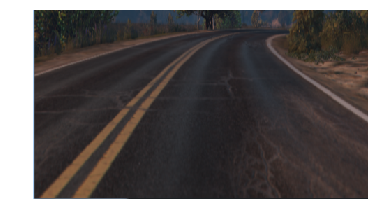

In [10]:
show_saved_data(120)

In [5]:
def roi(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    masked = cv2.bitwise_and(img, mask)
    return masked

In [6]:
def draw_lines(img,lines):
    for line in lines:
        coords = line[0]
        cv2.line(img, (coords[0], coords[1]), (coords[2], coords[3]), [255,255,255], 3)

array([[[  2, 200,   2,   0]],

       [[294,  84, 479, 171]],

       [[295,  84, 479, 169]],

       [[  1, 200,   1,   0]],

       [[  3, 200,   3,   0]],

       [[336,  95, 479, 153]],

       [[442, 151, 479, 168]],

       [[404, 125, 479, 158]],

       [[358, 106, 468, 155]],

       [[117,  78, 128, 200]],

       [[328,  90, 394, 117]],

       [[364, 118, 405, 137]],

       [[358, 105, 393, 119]]], dtype=int32)

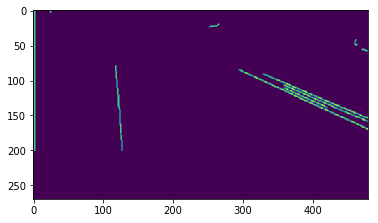

In [13]:
img, action = get_saved_data(10)
processed_img = cv2.Canny(img, threshold1=200, threshold2=300)
#processed_img = cv2.Canny(gray_img, threshold1=200, threshold2=300)
processed_img = cv2.GaussianBlur(processed_img, (3,3), 0 )    
vertices = np.array([[0,200],[0,0],[800,0],[800,200]], np.int32)
processed_img = roi(processed_img, [vertices])
lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 120, 20, 35)
plt.imshow(processed_img)    
lines

## color exctraction

In [14]:
#https://docs.opencv.org/master/df/d9d/tutorial_py_colorspaces.html
#https://stackoverflow.com/questions/21737613/image-of-hsv-color-wheel-for-opencv
org_img = train_data[120][0]
while(1):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(org_img, cv2.COLOR_BGR2HSV)

    # define range of yellow color in HSV
    lower_yellow = np.array([15, 100, 100])
    upper_yellow = np.array([45,255,255])

    lower_white = np.array([0, 0, 0])
    upper_white = np.array([100,0,255])
    
    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(org_img,org_img, mask= mask)
    res1 = cv2.bitwise_and(org_img,org_img, mask= white_mask)
    cv2.imshow('org',org_img)
    cv2.imshow('mask',mask)
    cv2.imshow('yellow',res)
    
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

## color clustering
- https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/

In [7]:
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    # return the histogram
    return hist

In [8]:
def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX
    # return the bar chart
    return bar

In [9]:
from sklearn.cluster import KMeans

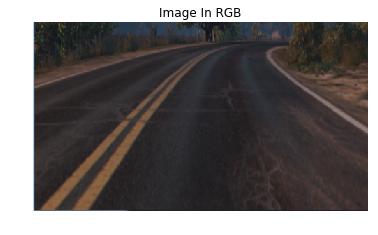

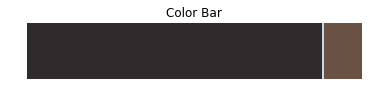

In [114]:
org_img = train_data[120][0]
rgb_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.axis("off")
plt.title('Image In RGB')
plt.imshow(rgb_img)

shaped_image = rgb_img.reshape((rgb_img.shape[0] * rgb_img.shape[1], 3))

clt = KMeans(n_clusters = 3)
clt.fit(shaped_image)
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)

# show our color bart
plt.figure()
plt.axis("off")
plt.title('Color Bar')
plt.imshow(bar)
plt.show()



https://blog.danielparker.com.au/background-colour-detection-using-opencv-and-python-22ed8655b243

In [10]:
from collections import Counter
def count_color(width, height,image):
    manual_count={}
    for y in range(0, width):
        for x in range(0,height):
            rgb = (image[x,y,2],image[x,y,1],image[x,y,0])
            if rgb in manual_count:
                manual_count[rgb] +=1
            else:
                manual_count[rgb] =1
    number_counter = Counter(manual_count).most_common(3)                
    return manual_count,number_counter

In [117]:
height, width, channels = bar.shape
print("image ", height, width,channels)
all_count, top_three = count_color(width, height,bar)
top_three

image  50 300 3


[((44, 43, 47), 13200), ((67, 81, 105), 1700), ((241, 217, 193), 100)]

## find a proper threashold for canny edge

In [11]:
def nothing(x):
    pass

In [12]:
img_noblur = train_data[10][0]
#img = cv2.blur(img_noblur, (7,7))
gray_img = cv2.cvtColor(img_noblur, cv2.COLOR_BGR2GRAY)   
canny_edge = cv2.Canny(gray_img, 0, 0)
cv2.imshow('org', img_noblur) 
cv2.imshow('gray', gray_img) 
cv2.imshow('canny_edge', canny_edge)
cv2.createTrackbar('min_value','canny_edge',0,500,nothing)
cv2.createTrackbar('max_value','canny_edge',0,500,nothing)
 
while(1):
    cv2.imshow('canny_edge', canny_edge)
    #p_img = cv2.GaussianBlur(canny_edge, (3,3), 0 )  
    #cv2.imshow('after gaussian', p_img)

    min_value = cv2.getTrackbarPos('min_value', 'canny_edge')
    max_value = cv2.getTrackbarPos('max_value', 'canny_edge')
    
    if cv2.waitKey(0) & 0xFF == ord('r'):
        canny_edge = cv2.Canny(gray_img, threshold1=min_value,threshold2=max_value)
        print("set min to ", min_value,  "set max to", max_value)
        
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break
    

set min to  0 set max to 0
set min to  83 set max to 198
set min to  83 set max to 198
set min to  34 set max to 124
set min to  34 set max to 124
set min to  10 set max to 34


## canny to dectct the edge

In [50]:
#https://henrydangprg.com/2016/12/11/canny-edge-detection-in-python-with-opencv/
def detect_edge(rgb_image):
    gray_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)   
    #processed_img = cv2.Canny(rgb_image, threshold1=200, threshold2=300)
    processed_img = cv2.Canny(gray_img, threshold1=130, threshold2=226)
    processed_img = cv2.GaussianBlur(processed_img, (3,3), 0 )    
    #vertices = np.array([[0,200],[0,0],[800,0],[800,200]], np.int32)
    #processed_img = roi(processed_img, [vertices])
    #plt.imshow(processed_img)    
    
    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 120, 20, 35)
    #print(lines)
    #draw_lines(processed_img,lines)    
    return processed_img, lines

In [51]:
def display_image_win(pos,img):
    cv2.imshow(pos, img)

def destroy_win():    
    while True:
        #if cv2.waitKey(25) & 0xFF == ord('q'):
        if cv2.waitKey(0) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break    

In [52]:
img, action = get_saved_data(10)
display_image_win('window',img)
new_screen, hlines= detect_edge(img)
#display_image_win('window2',gray_img)
display_image_win('window2',new_screen)
draw_lines(new_screen,hlines)    
display_image_win('window3',new_screen)
#cv2.circle(original_image,(480,270),10,[255,0,0])
destroy_win()

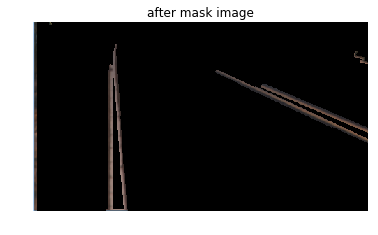

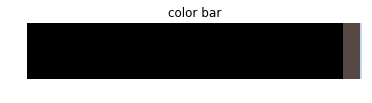

image  270 480 3


[((0, 0, 0), 122461), ((238, 204, 171), 270), ((245, 231, 216), 51)]

In [126]:
#https://www.pyimagesearch.com/2014/08/04/opencv-python-color-detection/
ret, mask = cv2.threshold(new_screen, 10, 255, cv2.THRESH_BINARY)
img2_fg = cv2.bitwise_and(img,img,mask = mask)
#
rgb_img = show_rgb_img(img2_fg,"after mask image")

shaped_image = rgb_img.reshape((rgb_img.shape[0] * rgb_img.shape[1], 3))

clt = KMeans(n_clusters = 3)
clt.fit(shaped_image)
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)

# show our color bart
plt.figure()
plt.axis("off")
plt.title("color bar")
plt.imshow(bar)
plt.show()

#try_img=bar
#try_img= try_img.astype(np.uint8)

height, width, channels = rgb_img.shape
print("image ", height, width,channels)
all_count,top_two = count_color(width, height, rgb_img)
top_two

In [ ]:
def draw_lanes(img, lines, color=[0, 255, 255], thickness=3):

    # if this fails, go with some default line
    try:
        # finds the maximum y value for a lane marker 
        # (since we cannot assume the horizon will always be at the same point.)

        ys = []  
        for i in lines:
            for ii in i:
                ys += [ii[1],ii[3]]
        #print(lines)
        min_y = min(ys)
        max_y = 270
        mid_y = 200
        new_lines = []
        line_dict = {}

        for idx,i in enumerate(lines):
            for xyxy in i:
                # These four lines:
                # modified from http://stackoverflow.com/questions/21565994/method-to-return-the-equation-of-a-straight-line-given-two-points
                # Used to calculate the definition of a line, given two sets of coords.
                x_coords = (xyxy[0],xyxy[2])
                y_coords = (xyxy[1],xyxy[3])
                A = vstack([x_coords,ones(len(x_coords))]).T
                m, b = lstsq(A, y_coords)[0]

                # Calculating our new, and improved, xs
                x1 = (min_y-b) / m
                x2 = (max_y-b) / m

                line_dict[idx] = [m,b,[int(x1), min_y, int(x2), max_y]]
                new_lines.append([int(x1), min_y, int(x2), max_y])

        final_lanes = {}

        for idx in line_dict:
            final_lanes_copy = final_lanes.copy()
            m = line_dict[idx][0]
            b = line_dict[idx][1]
            line = line_dict[idx][2]
            
            if len(final_lanes) == 0:
                final_lanes[m] = [ [m,b,line] ]
                
            else:
                found_copy = False

                for other_ms in final_lanes_copy:
                    if not found_copy:
                        if abs(other_ms*1.2) > abs(m) > abs(other_ms*0.8):
                            if abs(final_lanes_copy[other_ms][0][1]*1.2) > abs(b) > abs(final_lanes_copy[other_ms][0][1]*0.8):
                                final_lanes[other_ms].append([m,b,line])
                                found_copy = True
                                break
                        else:
                            final_lanes[m] = [ [m,b,line] ]

        line_counter = {}

        for lanes in final_lanes:
            line_counter[lanes] = len(final_lanes[lanes])

        top_lanes = sorted(line_counter.items(), key=lambda item: item[1])[::-1][:2]
        
        #print(top_lanes)
        lane1_id = top_lanes[0][0]
        lane2_id = top_lanes[1][0]

        def average_lane(lane_data):
            x1s = []
            y1s = []
            x2s = []
            y2s = []
            for data in lane_data:
                x1s.append(data[2][0])
                y1s.append(data[2][1])
                x2s.append(data[2][2])
                y2s.append(data[2][3])
            return int(mean(x1s)), int(mean(y1s)), int(mean(x2s)), int(mean(y2s))

        l1_x1, l1_y1, l1_x2, l1_y2 = average_lane(final_lanes[lane1_id])
        l2_x1, l2_y1, l2_x2, l2_y2 = average_lane(final_lanes[lane2_id])

        return [l1_x1, l1_y1, l1_x2, l1_y2], [l2_x1, l2_y1, l2_x2, l2_y2]
    except Exception as e:
        print(str(e))

In [ ]:
abs(-39)
#cv2.circle?

In [ ]:
def display_lanes(rgb_image):
    original_image = rgb_image   
    #gray_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
    processed_img = cv2.Canny(rgb_image, threshold1=200, threshold2=300)
    processed_img = cv2.GaussianBlur(processed_img, (3,3), 0 )    
    vertices = np.array([[0,200],[0,0],[800,0],[800,200]], np.int32)
    processed_img = roi(processed_img, [vertices])
#    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 180, 20, 15)
    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 120, 20, 35)
    
    try:
        l1, l2 = draw_lanes(original_image,lines,1)
        cv2.line(original_image, (l1[0], l1[1]), (l1[2], l1[3]), [0,255,0], 10)
        cv2.line(original_image, (l2[0], l2[1]), (l2[2], l2[3]), [0,255,0], 10)
        cv2.circle(original_image,(480,270),10,[255,0,0])
        for xyxy in lines:
            
#         print('line 1 point1 = ',l1[0],l1[1])
#         print('line 2 point1 = ',l2[0],l2[1])
#         print('line 1 point2 = ',l1[2],l1[3])
#         print('line 2 point2 = ',l2[2],l2[3])
        #cv2.circle(original_image,(l2[2],l2[3]),10,[0,255,0])
    except Exception as e:
        print(str(e))
        pass
    try:
        for coords in lines:
            coords = coords[0]
            try:
                cv2.line(processed_img, (coords[0], coords[1]), (coords[2], coords[3]), [255,0,0], 3)
            except Exception as e:
                print(str(e))
    except Exception as e:
        print(str(e))
    
    return original_image, processed_img

<img src='./image/find_lane.png',width=500>
* 左上 x,y=(0,0)
* 左下 (0,270)
* 右上 (480,0)
* 右下 (480,270)

In [ ]:
img, action = get_saved_data(13)
original_image = img   
#gray_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)
processed_img = cv2.Canny(img, threshold1=200, threshold2=300)
processed_img = cv2.GaussianBlur(processed_img, (3,3), 0 )    
vertices = np.array([[0,200],[0,0],[800,0],[800,200]], np.int32)
processed_img = roi(processed_img, [vertices])
#    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 180, 20, 15)
lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 120, 20, 35)
print(lines)
display_image_win('window',img)
org_screen, new_screen= display_lanes(img)
display_image_win('window2',new_screen)
display_image_win('window3',org_screen)

destroy_win()